# Detailed Exploration of Universal Gate Set for Intermediate Zeta

## Header

In [2]:
import numpy as np
import QDYN
from QDYN.shutil import mkdir
from QDYN.pulse import Pulse, pulse_tgrid
from QDYN.gate2q import Gate2Q
from QDYN.linalg import norm, vectorize
from os.path import join
from notebook_utils import (
    get_zeta_table, plot_zeta_data, filter_table, get_logical_energies_table,
    get_stage4_table, bare_decomposition, get_transition_table, J_target,
    get_w_d_from_config)
from mgplottools.io import writetotxt
from select_for_stage4 import GATE_RE, GATE_IM, GATE
from generate_zeta_universal import write_config
from analytical_pulses import AnalyticalPulse
from run_oct import propagate
from collections import OrderedDict
from zeta_systematic_variation import systematic_variation
import pandas as pd
import QDYNTransmonLib
from mgplottools.io import writetotxt

In [3]:
H_left = GATE['H_left']
H_right = GATE['H_right']
S_left = GATE['Ph_left']
S_right = GATE['Ph_right']
def write_target_gate_dat(rf, gate):
    writetotxt(join(rf, 'target_gate.dat'), GATE_RE[gate], GATE_IM[gate])

In [4]:
def J_PE(U):
    if U is None:
        return None
    else:
        C = U.closest_unitary().concurrence()
        max_loss = np.max(1.0 - U.logical_pops())
        return J_target('PE', C, max_loss)

def F_avg_H_left(U):
    if U is None:
        return None
    else:
        return U.F_avg(H_left)
    
def F_avg_H_right(U):
    if U is None:
        return None
    else:
        return U.F_avg(H_right)

def F_avg_S_left(U):
    if U is None:
        return None
    else:
        return U.F_avg(S_left)
    
def F_avg_S_right(U):
    if U is None:
        return None
    else:
        return U.F_avg(S_right)

In [5]:
from multiprocessing import Process
import os
def system(cmd):
    p = Process(target=os.system, args=(cmd,))
    p.start()
    return p

In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [7]:
get_zeta_table = QDYN.memoize.memoize(get_zeta_table)
get_zeta_table.load('zeta_table.cache')

In [8]:
zeta_table = get_zeta_table('./runs_050_RWA', T=50)

In [9]:
w_max = 1.0 # minimum frequency in the rotating frame to be resolved. (for calculation of nt)

In [10]:
n_qubit = 5; n_cavity = 6

In [11]:
def mark_freqs(rf, transition_table):
    """Return the frequencies that should be highlighted in the spectrum plot"""
    w_d = get_w_d_from_config(join(rf, 'config'))
    w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
    w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
    w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
    w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz
    wc = 5.75 # GHZ
    w2 = 6.32 # GHz
    w1 = 6.00 # GHz
    return [(w1_dressed0-w_d, {'color':'black', 'ls':'--'}),
            (w1_dressed1-w_d, {'color':'black', 'ls':'--'}),
            (w2_dressed0-w_d, {'color':'gray', 'ls':'--'}),
            (w2_dressed1-w_d, {'color':'gray', 'ls':'--'}),
            (wc-wd,           {'color':'gray', 'ls':'dotted'}),
            (w2-wd,           {'color':'gray', 'ls':'-.'}),
            (w1-wd,           {'color':'black', 'ls':'-.'})]

## Properties of the Hamiltonian

In [12]:
w1 = 6.00 # GHz
w2 = 6.32 # GHz
wc = 5.75 # GHZ
root = './runs_zeta_detailed/w2_%dMHz_wc_%dMHz' % (w2*1000, wc*1000)
mkdir(root)

* what is the the entangling energy?

In [13]:
zeta = float(filter_table(zeta_table, [(w2, wc),])['zeta [MHz]']); zeta

-16.716000000000008

In [14]:
T_entangling = 500.0 / abs(zeta); T_entangling # ns

29.911462072266076

###  PE

* Verify the PE. What do the logical eigenstates look like? What are the dressed qubit levels? What required spectral resolution do we anticipate?

In [15]:
T = T_entangling
rf = join(root, 'verify_PE'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

concurrence: 1.00000


In [16]:
psi = {}; psi['00'], psi['01'], psi['10'], psi['11'] \
= np.genfromtxt(join(rf, 'logical_states.dat'), unpack=True, usecols=range(4))
for label in ['00', '01', '10', '11']:
    print("%s = %s" % (label, bare_decomposition(psi[label], n_qubit, n_cavity)))

00 = 100.0% {000}
01 = 1.5% {001} + 98.4% {010}
10 = 5.7% {001} + 0.3% {010} + 94.0% {100}
11 = 33.1% {020} + 1.1% {101} + 65.8% {110}


In [17]:
transition_table = get_transition_table(filter_table(zeta_table, [(w2, wc),]))
transition_table.reset_index(drop=True)

,E01 - E00 [MHz],E10 - E00 [MHz],E11 - E10 [MHz],E11 - E01 [MHz],bare w2 [MHz],bare w1 [MHz]
0,6328.69,6017.286,6311.974,6000.57,6320,6000


In [18]:
w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz

In [19]:
print("Separation of dressed frequencies, left qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E01 [MHz]']) - float(transition_table['E10 - E00 [MHz]'])))
print("Separation of dressed frequencies, right qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E10 [MHz]']) - float(transition_table['E01 - E00 [MHz]'])))

Separation of dressed frequencies, left qubit: 16.716 MHz
Separation of dressed frequencies, right qubit: 16.716 MHz


In [20]:
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')

Spectral resolution of pulse: 33.4 MHz


###  SQ

* Verify the local gate

In [21]:
T = 2*T_entangling
rf = join(root, 'verify_SQ'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

Spectral resolution of pulse: 16.7 MHz
concurrence: 0.00007


In [22]:
T = 4*T_entangling
rf = join(root, 'verify_SQ_2cycles'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

Spectral resolution of pulse: 8.4 MHz
concurrence: 0.00014


## Improving the PE

* Can we compress the PE by adding a pulse and OCT?

In [24]:
compression = 0.7
wd = 0.5*(w1+w2)
rf = join(root, 'compress_PE_%.1f' % compression); mkdir(rf)

In [25]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/compress_PE_0.7'

In [26]:
# write runfolder
T = compression*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')

In [27]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 200, 500]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=J_PE, n_procs=40)

,E0,w_L,fig_of_merit
20,200,6.160000,0.065954
11,50,6.160000,0.108181
0,0,6.000000,0.111862
1,0,6.320000,0.111862
2,0,6.160000,0.111862
3,0,6.017286,0.111862
4,0,6.000570,0.111862
5,0,6.008928,0.111862
6,0,6.328690,0.111862
7,0,6.311974,0.111862


In [28]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 200.0, 'T': T, 'w_L': 6.16, 'w_d': 6.16},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [29]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True, keep=None)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.944892
Loss: 0.005964


In [37]:
U_guess_closest_PE = U_guess.closest_PE()

In [39]:
U_guess.F_avg(U_guess_closest_PE)

0.98304954708932146

In [30]:
proc = system("./run_oct.py --target=PE --continue --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [32]:
proc.join(); U = propagate(rf, 'pulse.dat', rwa=True, force=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

  878  2.441503128017E-03  1.021673162694E-07  0.000000000000E+00  2.44160529533
  879  2.441275218414E-03  1.019170565411E-07  0.000000000000E+00  2.44137713547
  880  2.441047888456E-03  1.016675715323E-07  0.000000000000E+00  2.44114955602
  881  2.440821136252E-03  1.014188581838E-07  0.000000000000E+00  2.44092255511
  882  2.440594960006E-03  1.011709134452E-07  0.000000000000E+00  2.44069613091
  883  2.440369357867E-03  1.009237342714E-07  0.000000000000E+00  2.44047028160
  884  2.440144328032E-03  1.006773176279E-07  0.000000000000E+00  2.44024500535
  885  2.439919868680E-03  1.004316604860E-07  0.000000000000E+00  2.44002030034
  886  2.439695978011E-03  1.001867598248E-07  0.000000000000E+00  2.43979616477
  887  2.439472654232E-03  9.994261263395E-08  0.000000000000E+00  2.43957259684


In [38]:
print("Concurrence: %f" % U.closest_unitary().concurrence())
print("Loss: %f" % U.pop_loss())

Concurrence: 0.955904
Loss: 0.002136


In [35]:
U_closest_PE = U.closest_PE()

In [36]:
U.F_avg(U_closest_PE)

0.98903817483804313

In [40]:
1 - U.F_avg(U_closest_PE)

0.010961825161956873

## Implementation of Single-Qubit Gate

### $H_L$ at $T = 2 T_\pi$ ####

In [189]:
rf = join(root, '1cycle_H_left'); mkdir(rf)
wd = 0.5*(w1+w2)

In [190]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/1cycle_H_left'

In [191]:
T = 2*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [192]:
T

59.82292414453215

In [193]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 100, 150]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_left, n_procs=40)

,E0,w_L,fig_of_merit
27,150,6.000000,0.193467
31,150,6.000570,0.195021
15,50,6.328690,0.199310
4,0,6.000570,0.199350
0,0,6.000000,0.199350
1,0,6.320000,0.199350
2,0,6.160000,0.199350
3,0,6.017286,0.199350
5,0,6.008928,0.199350
6,0,6.328690,0.199350


In [194]:
pulse_ff = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse_ff.write(join(rf, 'pulse_ff.json'))
U_ff = propagate(rf, 'pulse_ff.json', rwa=True, force=True, keep=None);

In [195]:
U_ff.pop_loss()

0.0047916360641748756

In [196]:
U_ff.concurrence()

6.8423887941836993e-05

In [198]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': 6.017286, 'w_d': 6.017286},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [199]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.939675
Loss: 0.028905


Note the high concurrence -- this is because the guess pulse implements the Hadamard in population, but not in phases

In [201]:
U_guess.F_avg(H_left)

0.48383223068241632

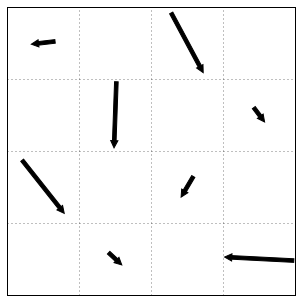

In [203]:
U_guess.arrow_plot()

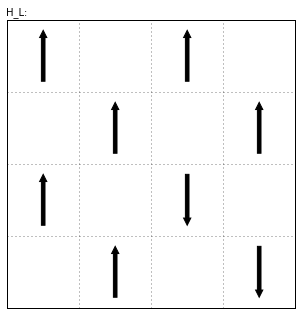

In [204]:
H_left.arrow_plot()

In [48]:
proc2 = system("./run_oct.py --continue --threads --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [52]:
proc2.join()

In [50]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/1cycle_H_left'

In [58]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

 2380  1.027234049713E-02  1.014422339535E-07  0.000000000000E+00  1.02724419393
 2381  1.027212597375E-02  1.012737457218E-07  0.000000000000E+00  1.02722272474
 2382  1.027191180872E-02  1.011055950323E-07  0.000000000000E+00  1.02720129143
 2383  1.027169800128E-02  1.009377816437E-07  0.000000000000E+00  1.02717989390
 2384  1.027148455073E-02  1.007703053068E-07  0.000000000000E+00  1.02715853210
 2385  1.027127145633E-02  1.006031657705E-07  0.000000000000E+00  1.02713720594
 2386  1.027105871730E-02  1.004363627747E-07  0.000000000000E+00  1.02711591536
 2387  1.027084633293E-02  1.002698960581E-07  0.000000000000E+00  1.02709466028
 2388  1.027063430250E-02  1.001037653547E-07  0.000000000000E+00  1.02707344062
 2389  1.027042262523E-02  9.993797039167E-08  0.000000000000E+00  1.02705225632


In [59]:
U.concurrence()

0.0055463905609073232

In [60]:
U.pop_loss()

0.010249457290468555

In [61]:
1-U.F_avg(H_left)

0.01026622966796964

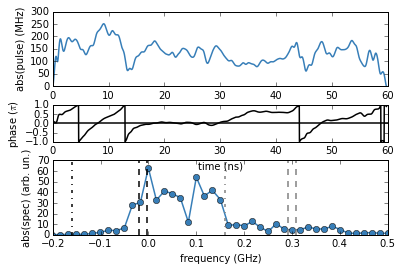

In [67]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-0.2, wmax=0.5)

/data/goerz/jobs/ConstrainedTransmon/venv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


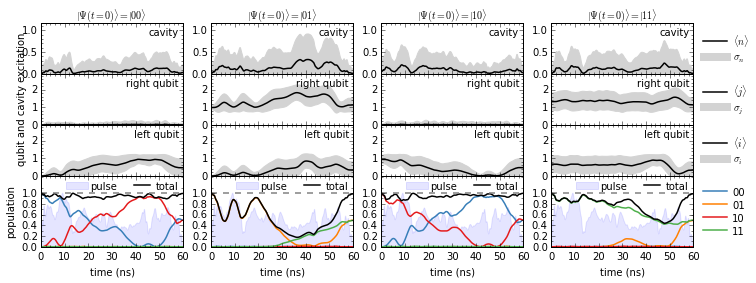

In [70]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

### $H_R$ at $T = 2 T_\pi$ ####

In [215]:
rf = join(root, '1cycle_H_right'); mkdir(rf)
wd = 0.5*(w1+w2)

In [216]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/1cycle_H_right'

In [170]:
T = 2*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_right')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [173]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 100, 150]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_right, n_procs=40)

,E0,w_L,fig_of_merit
31,150,6.000570,0.192937
27,150,6.000000,0.193279
21,100,6.017286,0.207752
32,150,6.008928,0.209284
35,150,6.320332,0.250141
28,150,6.320000,0.252204
23,100,6.008928,0.262510
34,150,6.311974,0.272210
30,150,6.017286,0.275249
33,150,6.328690,0.303442


In [207]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 50.0, 'T': T, 'w_L': 6.328690, 'w_d': 6.328690},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [208]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True, keep=None)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.665320
Loss: 0.004953


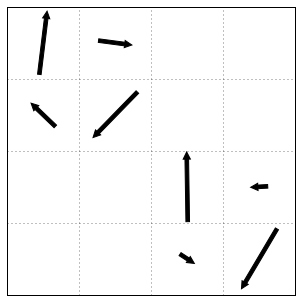

In [209]:
U_guess.arrow_plot()

In [210]:
U_guess.F_avg(H_right)

0.53444823643626727

In [217]:
proc = system("./run_oct.py --threads --continue --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [ ]:
proc.join()

In [ ]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

In [ ]:
U.concurrence()

In [ ]:
U.pop_loss()

In [ ]:
1-U.F_avg(H_right)

In [ ]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-0.2, wmax=0.5)

In [ ]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

### $S_L$ at $T = 2 T_\pi$ ####

In [51]:
rf = join(root, '1cycle_Ph_left'); mkdir(rf)
wd = 0.5*(w1+w2)

In [52]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/1cycle_Ph_left'

In [53]:
T = 2*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'Ph_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [54]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 100, 150]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_S_left, n_procs=40)

,E0,w_L,fig_of_merit
33,150,6.328690,0.199904
27,150,6.000000,0.206196
31,150,6.000570,0.208967
18,100,6.000000,0.209566
22,100,6.000570,0.211014
24,100,6.328690,0.215806
14,50,6.008928,0.240203
13,50,6.000570,0.241513
9,50,6.000000,0.241946
15,50,6.328690,0.245410


In [55]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 100.0, 'T': T, 'w_L': 6.017286, 'w_d': 6.017286},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [56]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.939675
Loss: 0.028905


In [57]:
U_guess.F_avg(S_left)

0.4284662931429214

In [58]:
proc2 = system("./run_oct.py --continue --threads --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [60]:
proc2

<Process(Process-91, started)>

In [ ]:
proc2.join()

In [47]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

 8222  1.062208875782E-01  2.848030113350E-04  0.000000000000E+00  1.06505690589
 8223  1.056680033271E-01  2.770644809240E-04  0.000000000000E+00  1.05945067808
 8224  1.051299823406E-01  2.696141624899E-04  0.000000000000E+00  1.05399596503
 8225  1.046062535382E-01  2.624499953856E-04  0.000000000000E+00  1.04868703533
 8226  1.040962543225E-01  2.555677772878E-04  0.000000000000E+00  1.04351822099
 8227  1.035994343095E-01  2.489614178659E-04  0.000000000000E+00  1.03848395727
 8228  1.031152581999E-01  2.426233695069E-04  0.000000000000E+00  1.03357881569
 8229  1.026432078445E-01  2.365450343329E-04  0.000000000000E+00  1.02879752878
 8230  1.021827836679E-01  2.307170887924E-04  0.000000000000E+00  1.02413500756
 8231  1.017335056380E-01  2.251297151594E-04  0.000000000000E+00  1.01958635353


In [48]:
U.concurrence()

0.18041820149045484

In [49]:
U.pop_loss()

0.094886973698971255

In [50]:
1-U.F_avg(S_left)

0.10036419923521278

In [ ]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-0.2, wmax=0.5)

In [ ]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

### $S_R$ at $T = 2 T_\pi$ ####

In [61]:
rf = join(root, '1cycle_Ph_right'); mkdir(rf)
wd = 0.5*(w1+w2)

In [62]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/1cycle_Ph_right'

In [63]:
T = 2*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'Ph_right')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [64]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 100, 150]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_S_right, n_procs=40)

,E0,w_L,fig_of_merit
26,100,6.320332,0.199353
19,100,6.320000,0.199412
16,50,6.311974,0.199643
20,100,6.160000,0.200019
11,50,6.160000,0.200850
10,50,6.320000,0.201223
17,50,6.320332,0.201328
8,0,6.320332,0.203590
0,0,6.000000,0.203590
6,0,6.328690,0.203590


In [65]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 150.0, 'T': T, 'w_L': 6.328690, 'w_d': 6.328690},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [66]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.864953
Loss: 0.006815


In [67]:
U_guess.F_avg(S_right)

0.22096234888594521

In [68]:
proc3 = system("./run_oct.py --continue --threads --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [ ]:
proc3.join()

In [ ]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

In [ ]:
U.concurrence()

In [ ]:
U.pop_loss()

In [ ]:
1-U.F_avg(S_right)

In [ ]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-0.2, wmax=0.5)

In [ ]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

### All Single-Qubit gates at $T = 2T_\pi$, no pre-simplex ####

In [23]:
T = 2*T_entangling
nt = int(max(2000, 100 * w_max * T))
rf_HL = join(root, 'no_simplex_H_left'); mkdir(rf_HL)
rf_HR = join(root, 'no_simplex_H_right'); mkdir(rf_HR)
rf_SL = join(root, 'no_simplex_Ph_left'); mkdir(rf_SL)
rf_SR = join(root, 'no_simplex_Ph_right'); mkdir(rf_SR)
write_target_gate_dat(rf_HL, 'H_left')
write_target_gate_dat(rf_HR, 'H_right')
write_target_gate_dat(rf_SL, 'Ph_left')
write_target_gate_dat(rf_SR, 'Ph_right')
for rf in [rf_HL, rf_SL]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w1_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': w1_dressed0, 'w_d': w1_dressed0},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.pulse().write(join(rf, 'pulse.guess'))
for rf in [rf_HR, rf_SR]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w2_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': w2_dressed0, 'w_d': w2_dressed0},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.pulse().write(join(rf, 'pulse.guess'))

In [70]:
rf_HL

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/no_simplex_40_H_left'

In [24]:
proc_ns1 = system("./run_oct.py --rwa --threads --continue {rf}".format(rf=rf_HL))

In [28]:
proc_ns3

<Process(Process-3, started)>

In [26]:
proc_ns2 = system("./run_oct.py --rwa --threads --continue {rf}".format(rf=rf_HR))
proc_ns3 = system("./run_oct.py --rwa --threads --continue {rf}".format(rf=rf_SL))
proc_ns4 = system("./run_oct.py --rwa --threads --continue {rf}".format(rf=rf_SR))

See handwritten notes for analysis

### All Single-Qubit gates at $T = 40$ ns, no pre-simplex ####

In [29]:
T = 40
nt = int(max(2000, 100 * w_max * T))
rf_HL = join(root, 'no_simplex_40_H_left'); mkdir(rf_HL)
rf_HR = join(root, 'no_simplex_40_H_right'); mkdir(rf_HR)
rf_SL = join(root, 'no_simplex_40_Ph_left'); mkdir(rf_SL)
rf_SR = join(root, 'no_simplex_40_Ph_right'); mkdir(rf_SR)
write_target_gate_dat(rf_HL, 'H_left')
write_target_gate_dat(rf_HR, 'H_right')
write_target_gate_dat(rf_SL, 'Ph_left')
write_target_gate_dat(rf_SR, 'Ph_right')
for rf in [rf_HL, rf_SL]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w1_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': w1_dressed0, 'w_d': w1_dressed0},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.pulse().write(join(rf, 'pulse.guess'))
for rf in [rf_HR, rf_SR]:
    write_config(join(rf, 'config'), T, nt, wc, w2, wd=w2_dressed0,
                 gate="target_gate.dat", J_T='SM', prop_guess='F')
    pulse = AnalyticalPulse('1freq_rwa', T, nt,
                parameters={'E0': 100.0, 'T': T, 'w_L': w2_dressed0, 'w_d': w2_dressed0},
                t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
    pulse.pulse().write(join(rf, 'pulse.guess'))

In [30]:
proc_40_ns1 = system("./run_oct.py --rwa --threads --continue {rf}".format(rf=rf_HL))
proc_40_ns2 = system("./run_oct.py --rwa --threads --continue {rf}".format(rf=rf_HR))
proc_40_ns3 = system("./run_oct.py --rwa --threads --continue {rf}".format(rf=rf_SL))
proc_40_ns4 = system("./run_oct.py --rwa --threads --continue {rf}".format(rf=rf_SR))

See handwritten notes for analysis

###  $H_L$ at $T = 40$ ns

In [73]:
rf = join(root, '40ns_H_left'); mkdir(rf)
wd = 0.5*(w1+w2)

In [74]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/40ns_H_left'

In [75]:
T = 40
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [76]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 150, 200]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_left, n_procs=40)

,E0,w_L,fig_of_merit
35,200,6.320332,0.199895
28,200,6.320000,0.199941
33,200,6.328690,0.200095
13,50,6.000570,0.205955
9,50,6.000000,0.206426
34,200,6.311974,0.207215
24,150,6.328690,0.213598
26,150,6.320332,0.214984
19,150,6.320000,0.215212
14,50,6.008928,0.218037


In [77]:
pulse_ff = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse_ff.write(join(rf, 'pulse_ff.json'))
U_ff = propagate(rf, 'pulse_ff.json', rwa=True, force=True, keep=None);

In [78]:
U_ff.pop_loss()

0.0032076018309659116

In [79]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 200.0, 'T': T, 'w_L': 6.008928, 'w_d': 6.008928},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [80]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.701812
Loss: 0.090381


In [81]:
proc3 = system("./run_oct.py --rwa --continue --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [83]:
proc3.join();

In [85]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

 9991  3.824610226788E-02  3.147617961048E-07  0.000000000000E+00  3.82464170296
 9992  3.824537824777E-02  3.147097166128E-07  0.000000000000E+00  3.82456929574
 9993  3.824465434773E-02  3.146576450282E-07  0.000000000000E+00  3.82449690053
 9994  3.824393056769E-02  3.146055813531E-07  0.000000000000E+00  3.82442451732
 9995  3.824320690765E-02  3.145535255883E-07  0.000000000000E+00  3.82435214611
 9996  3.824248336759E-02  3.145014777354E-07  0.000000000000E+00  3.82427978690
 9997  3.824175994751E-02  3.144494377947E-07  0.000000000000E+00  3.82420743969
 9998  3.824103664737E-02  3.143974057691E-07  0.000000000000E+00  3.82413510447
 9999  3.824031346713E-02  3.143453816579E-07  0.000000000000E+00  3.82406278125
10000  3.823959040682E-02  3.142933654637E-07  0.000000000000E+00  3.82399047001


In [86]:
U.concurrence()

0.12392795224994915

In [87]:
U.pop_loss()

0.034937870393300985

In [88]:
1-U.F_avg(H_left)

0.037579246125521215

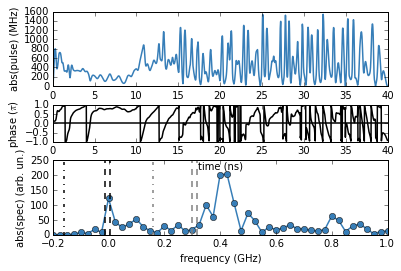

In [91]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-0.2, wmax=1.0)

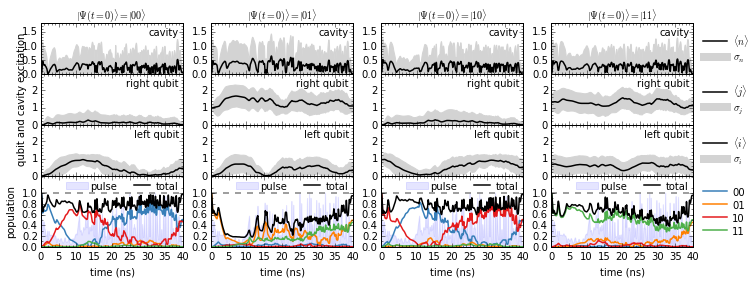

In [92]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

###  $H_R$ at $T = 40$ ns

In [93]:
rf = join(root, '40ns_H_right'); mkdir(rf)
wd = 0.5*(w1+w2)

In [94]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/40ns_H_right'

In [95]:
T = 40
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_right')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [96]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 150, 200]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_right, n_procs=40)

,E0,w_L,fig_of_merit
32,200,6.008928,0.191867
21,150,6.017286,0.193300
30,200,6.017286,0.193921
23,150,6.008928,0.215380
31,200,6.000570,0.223952
27,200,6.000000,0.226871
22,150,6.000570,0.255674
18,150,6.000000,0.258497
34,200,6.311974,0.295725
33,200,6.328690,0.310385


In [97]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 200.0, 'T': T, 'w_L': 6.160000, 'w_d': 6.160000},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [98]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.855990
Loss: 0.005123


In [99]:
U_guess.F_avg(H_right)

0.40103092217036956

In [110]:
proc4 = system("./run_oct.py --rwa --continue --keep --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [111]:
proc4.join();

In [118]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

 6026  5.173541671816E-02  1.003383509265E-07  0.000000000000E+00  5.17355170565
 6027  5.173519841492E-02  1.002987347934E-07  0.000000000000E+00  5.17352987136
 6028  5.173498019571E-02  1.002591436872E-07  0.000000000000E+00  5.17350804548
 6029  5.173476206044E-02  1.002195775896E-07  0.000000000000E+00  5.17348622800
 6030  5.173454400914E-02  1.001800364811E-07  0.000000000000E+00  5.17346441891
 6031  5.173432604168E-02  1.001405203424E-07  0.000000000000E+00  5.17344261822
 6032  5.173410815804E-02  1.001010291548E-07  0.000000000000E+00  5.17342082590
 6033  5.173389035817E-02  1.000615628985E-07  0.000000000000E+00  5.17339904197
 6034  5.173367264201E-02  1.000221215554E-07  0.000000000000E+00  5.17337726641
 6035  5.173345500951E-02  9.998270510614E-08  0.000000000000E+00  5.17335549922


In [119]:
U.concurrence()

0.03251355404955826

In [120]:
U.pop_loss()

0.050680294523667735

In [121]:
1-U.F_avg(H_right)

0.051522823173379195

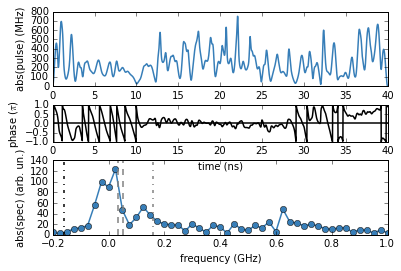

In [122]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-0.2, wmax=1.0)

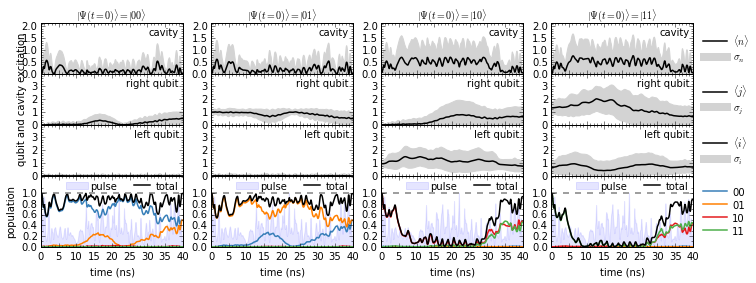

In [123]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()

###  $H_L$ at $T = 40$ ns, two-tone

In [156]:
rf = join(root, '40ns_H_left_two_tone'); mkdir(rf)
wd = 0.25*(w1_dressed0+w1_dressed1+w2_dressed1+w2_dressed1)

In [157]:
rf

'./runs_zeta_detailed/w2_6320MHz_wc_5750MHz/40ns_H_left_two_tone'

In [140]:
T = 40
nt = 4000
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat",
             J_T='SM', prop_guess='F')

In [141]:
pulse = AnalyticalPulse('2freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 
                        'freq_1': 0.5*(w1_dressed0+w1_dressed1),
                        'freq_2': 0.5*(w2_dressed1+w2_dressed1),
                        'a_1': 1.0, 'a_2': 0.1, 'phi':0,
                        'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 10, 20, 50, 70, 150, 200]), ]),
            fig_of_merit=F_avg_H_right, n_procs=40)

,E0,fig_of_merit
6,200,0.197370
5,150,0.226808
4,70,0.330921
3,50,0.352684
2,20,0.370634
1,10,0.373010
0,0,0.373799


In [142]:
pulse = AnalyticalPulse('2freq_rwa', T, nt,
            parameters={'E0': 50.0, 'T': T, 
                        'freq_1': 0.5*(w1_dressed0+w1_dressed1),
                        'freq_2': 0.5*(w2_dressed1+w2_dressed1),
                        'a_1': 1.0, 'a_2': 0.1, 'phi':0,
                        'w_d': 0.25*(w1_dressed0+w1_dressed1+w2_dressed1+w2_dressed1)},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))


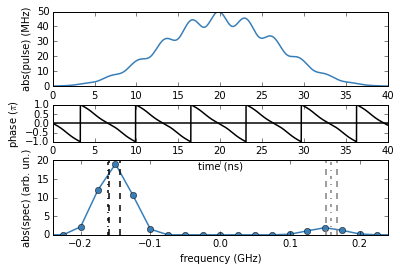

In [145]:
pulse.pulse().show(mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', freq_unit='GHz')

In [146]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.923122
Loss: 0.015143


In [154]:
proc5 = system("./run_oct.py --rwa --continue --nt-min=6000 --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [158]:
proc5

<Process(Process-289, stopped)>

In [159]:
proc5.join();

In [160]:
U = propagate(rf, 'pulse.dat', rwa=True, force=True, keep=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

 5165  1.552174872520E-01  1.468536375479E-06  0.000000000000E+00  1.55218955788
 5166  1.552138035281E-01  1.467925753484E-06  0.000000000000E+00  1.55215271453
 5167  1.552101208112E-01  1.467315457246E-06  0.000000000000E+00  1.55211588126
 5168  1.552064391008E-01  1.466705487297E-06  0.000000000000E+00  1.55207905806
 5169  1.552027583964E-01  1.466095844162E-06  0.000000000000E+00  1.55204224492
 5170  1.551990786973E-01  1.465486528366E-06  0.000000000000E+00  1.55200544183
 5171  1.551954000031E-01  1.464877540434E-06  0.000000000000E+00  1.55196864880
 5172  1.551917223132E-01  1.464268880890E-06  0.000000000000E+00  1.55193186582
 5173  1.551880456269E-01  1.463660550255E-06  0.000000000000E+00  1.55189509287
 5174  1.551843699439E-01  1.463052549047E-06  0.000000000000E+00  1.55185832996


In [161]:
U.concurrence()

0.28540658077863768

In [162]:
U.pop_loss()

0.1251303477604595

In [163]:
1-U.F_avg(H_left)

0.14917356529389658

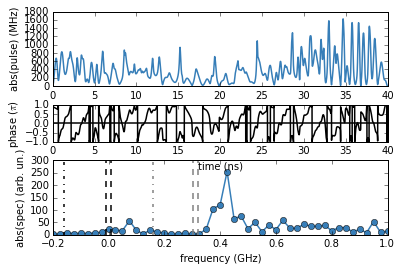

In [164]:
QDYN.pulse.Pulse(join(rf, 'pulse.dat')).show(
    mark_freqs=mark_freqs(rf, transition_table),
    mark_freq_points='o', wmin=-0.2, wmax=1.0)

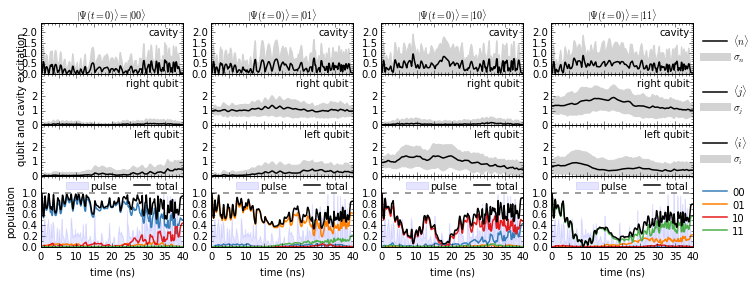

In [165]:
QDYNTransmonLib.popdyn.PopPlot(rf).show()